In [1]:
# Taken from MgH+ calculation with minor changes to calculate for CO (0, -2, +2) instead

__authors__ = ["Ruby Manderna, Lane Tolley, Figen Suchanek, Jonathan J. Foley, "]
__email__   = ["rmandern@uncc.edu, ptolley1@uncc.edu, suchanekf@wpunj.edu, jfoley19@uncc.edu, "]
__credits__ = ["Ruby Manderna, Lane Tolley, Figen Suchanek, Jonathan J. Foley"]
__copyright__ = "(c) 2008-2020, The Psi4Education Developers"
__license__   = "BSD-3-Clause"
__date__      = "2021-02-11"


import psi4
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
from numpy import linalg as LA
from psi4.driver.procrouting.response.scf_response import tdscf_excitations

from matplotlib import pyplot as plt


psi4.core.set_output_file('output.dat', False)

In [2]:
# set basis - calling level of theory (cc-pVDZ)
psi4.set_options({
    'basis':'cc-pVDZ'
})

# set the number of electronic states... this is the ground state + n_states more
# we will get 1 excited-state
n_states = 1

# set the number of bond lengths to compute the stretch along (CHANGE AS NECESSARY FOR CALCULATION TO CONVERGE + NICE GRAPH)
n_geoms = 17

# initialize geometry list
geoms = []

# initialize energy list... note
# there will be the ground state energy + n_states excited state energies
Es = np.zeros((n_states+1, n_geoms))

# initialize z-component of transition dipole list
mu_z = np.zeros((n_states, n_geoms))

# generate bond lengths
rs = []
for i in range(0,n_geoms):
    rs.append(1 + i*0.1) # Will change initial bond length as necessary for calculation to converge

# loop over bond lengths
ctr = 0
for i in rs:
    # generate the  molecule using a z-matrix and set the bond length - CHANGES FOR CHARGES
    # 0 1 line changed to -2 1 and +2 1 for ionized forms (First # for charge, 2nd # for singlet state)
    mol = psi4.geometry("""
    C
    O 1 """ + str(i) + """
   
    0 1  
    """)
    # save the geometry
    geoms.append(mol.geometry().to_array())
    psi4.set_options({
    'save_jk': True,
    })  
   
    # calculate and save the ground-state energy and wavefunction
    e, wfn = psi4.energy("b3lyp/cc-pVDZ", return_wfn=True, molecule=mol)
    
    # calculate the excited-state energies and save them to a dictionary called 'res'
    res = tdscf_excitations(wfn, states=n_states, triplets = "NONE")
    
    # parse the excitation energies from the 'res' dictionary 
    delta_e = [r["EXCITATION ENERGY"] for r in res]
    
    # parse the transition dipole moment from the 'res' dictionary
    mu = [r["ELECTRIC DIPOLE TRANSITION MOMENT (LEN)"] for r in res]
    Es[0,ctr] = e
    
    # store the results to the respective arrays
    for j in range(0, n_states):
        Es[j+1,ctr] = e + delta_e[j]
        # we only want the z-component which is index 2
        mu_z[j,ctr] = np.absolute(mu[j][2])

    
    # increment the counter!
    ctr += 1
    


In [3]:
# This will print all of the keys associated with the `res` dictionary.
print(res[0].keys())

# Take slices of information for Eg, Ee, and mu_eg only
Eg_array = np.copy(Es[0,:])
Ee_array = np.copy(Es[1,:])
tdm_array = np.copy(mu_z[0,:])

# fit all surfaces to a spline
Eg_spline = InterpolatedUnivariateSpline(rs, Eg_array, k=3)
Ee_spline = InterpolatedUnivariateSpline(rs, Ee_array, k=3)
mu_spline = InterpolatedUnivariateSpline(rs, tdm_array, k=3)

dict_keys(['EXCITATION ENERGY', 'ELECTRIC DIPOLE TRANSITION MOMENT (LEN)', 'OSCILLATOR STRENGTH (LEN)', 'ELECTRIC DIPOLE TRANSITION MOMENT (VEL)', 'OSCILLATOR STRENGTH (VEL)', 'MAGNETIC DIPOLE TRANSITION MOMENT', 'ROTATORY STRENGTH (LEN)', 'ROTATORY STRENGTH (VEL)', 'SYMMETRY', 'SPIN', 'RIGHT EIGENVECTOR ALPHA', 'LEFT EIGENVECTOR ALPHA', 'RIGHT EIGENVECTOR BETA', 'LEFT EIGENVECTOR BETA'])


In [4]:
R_val = 2.5

# Code to evaluate Eg_spline, Ee_spline, and mu_spline at R = 2.5 Angstroms
Eg_val = Eg_spline(2.5)
Ee_val = Ee_spline(2.5)
tdm_val = mu_spline(2.5)

print(Eg_val)
print(Ee_val)
print(tdm_val)

-112.84475921086899
-112.83157797129431
6.405977231429802e-14


In [5]:
# conversion factor for au -> eV
au_to_eV = 27.211

# Code to compute transition energy in atomic units and convert to eV
transition_energy_au = Ee_val-Eg_val
transition_energy_eV = transition_energy_au*27.211

print(transition_energy_au)
print(transition_energy_eV)



0.013181239574677761
0.35867471006655655


In [6]:
def Rabi_Hamiltonian(A_value, omega_value, r_value, g_spline, e_spline, tdm_spline):
    """Function to compute the Rabi Hamiltonian

    Arguments
    ----------
    A_value : float
        fundamental coupling strength
        
    omega_value : float
        photon energy
        
    r_value : float
        value of the bondlength
        
    g_spline : scipy spline object
        spline that is fit to the ground-state potential energy surface
        
    e_spline : scipy spline object
        spline that is fit to the excited-state potential energy surface
        
    tdm_spline : scipy spline object
        spline that is fit to the transition dipole moment surface
        
    Returns
    -------
    H : numpy array
        3x3 Rabi Hamiltonian matrix
    """
    
    # initialize 3x3 Hamiltonian matrix
    H = np.zeros((3,3))
    
    # pre-written first 2 diagonal entries
    H[0,0] = g_spline(r_value)
    H[1,1] = g_spline(r_value) + omega_value
    
    # ==> Code to compute 3rd diagonal entry H[2,2] goes here!
    H[2,2] = e_spline(r_value)
    # ==> Code to compute off-diagonal entries H[1,2] and H[2,1] goe here!
    H[1,2] = A_value * tdm_spline(r_value)
    H[2,1] = A_value * tdm_spline(r_value)
    # return the matrix
    return H


In [7]:
A_value = 0.003

H_Rabi = Rabi_Hamiltonian(A_value, transition_energy_au, R_val, Eg_spline, Ee_spline, mu_spline)

In [8]:
def polariton_surfaces(A_value, omega_value, r_values, g_spline, e_spline, tdm_spline):
   
    # initialize lp and up surfaces
    lp_surface = np.zeros_like(r_values)
    up_surface = np.zeros_like(r_values)
    
    # loop through r values, build Rabi Hamiltonian, diagonalize, and store!
    
    for i in range(0, len(r_values)):
        
        # if there is no coupling, then we don't need to diagonalize anything
        if A_value == 0:
            lp_surface[i] = g_spline(r_values[i]) + omega_value
            up_surface[i] = e_spline(r_values[i])
        
        # otherwise build Hamiltonian and diagonalize
        else:
            # Build the Rabi Hamiltonian
            H = Rabi_Hamiltonian(A_value, omega_value, r_values[i], g_spline, e_spline, tdm_spline)
            
            # diagonalize
            vals, vecs = LA.eigh(H)
            
            # store lp and up values
            lp_surface[i] = vals[1]
            up_surface[i] = vals[2]
    
    # return the surfaces
    return lp_surface, up_surface


In [9]:
# run this cell to compute the polariton PES
lp_surface, up_surface = polariton_surfaces(A_value, transition_energy_au, rs, Eg_spline, Ee_spline, mu_spline)

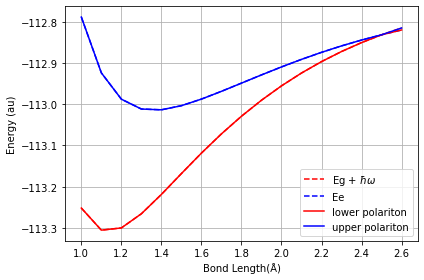

In [10]:
# Plotting figure
plt.figure()
# Four different plots
plt.plot(rs, Eg_spline(rs)+transition_energy_au, "r--", label="Eg + $\hbar \omega$")
plt.plot(rs, Ee_spline(rs), "b--", label="Ee")
plt.plot(rs, lp_surface, "red", label="lower polariton")
plt.plot(rs, up_surface, "blue", label="upper polariton")
# Make graph look nice
plt.grid(True)
plt.xlabel('Bond Length(\u212B)')
plt.ylabel('Energy (au)')
plt.legend()
plt.tight_layout()
# Zoom in as necessary to see y-value of intersection
# plt.ylim([-112.84,-112.82])
# plt.xlim([2.4,2.6])
plt.savefig(F'CO_0_Full.png', dpi=300)
# Figures saved: CO_0_Full.png, CO_0_Zoom.png, CO_-2_Full.png, CO_-2_Zoom.png, CO_+2_Zoom.png, CO_+2_Full.png
#plt.show()

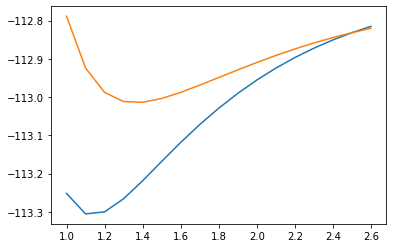

In [11]:
# Quick plot of upper and lower surfaces only
plt.figure()
plt.plot(rs, Eg_spline(rs)+transition_energy_au)
plt.plot(rs, Ee_spline(rs))

(2.5, -112.83 AU)

In [12]:
# Save arrays for export into "Widget" for Ers and g computation (Data exchange only coding done in "Widget")
print(F'Eg{Eg_array}')
np.save("Eg_array.npy", Eg_array)
print(F'Ee{Ee_array}')
np.save("Ee_array.npy", Ee_array)
print(F'tdm{tdm_array}')
np.save("tdm_array.npy", tdm_array)
print(rs)
np.save("rs_array.npy", rs)

Eg[-113.26490276 -113.31844383 -113.31306573 -113.27871903 -113.23182415
 -113.18126726 -113.13161973 -113.08499764 -113.04220612 -113.00342478
 -112.96856764 -112.93743741 -112.90978067 -112.88531147 -112.86373221
 -112.84475921 -112.82815915]
Ee[-112.78855855 -112.92386573 -112.98771894 -113.01160734 -113.01344808
 -113.00347965 -112.9874821  -112.96865381 -112.94876259 -112.92883052
 -112.90949504 -112.89117124 -112.87412033 -112.85848597 -112.84432058
 -112.83157797 -112.81989089]
tdm[3.52171738e-13 3.61121265e-14 5.90354764e-14 3.35999786e-14
 4.52186628e-14 9.57756400e-15 6.12336059e-15 8.00747154e-15
 1.44448506e-14 8.47849928e-15 2.82616643e-14 2.70055903e-14
 2.60635348e-14 6.90840682e-15 4.77308107e-14 6.40597723e-14
 4.39625888e-14]
[1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7000000000000002, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4000000000000004, 2.5, 2.6]
